# Percentile Forecast Optimization

This notebook focuses on percentile-based forecasts.
It optimizes percentile targets first without aggregation, then with an aggregation window.


## Setup


In [1]:
import pandas as pd
import random
from dataclasses import replace

from replenishment import (
    PercentileForecastOptimizationPolicy,
    RopPercentileForecastOptimizationPolicy,
    build_percentile_forecast_candidates_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    evaluate_aggregation_and_forecast_target_costs,
    evaluate_forecast_target_costs,
    generate_standard_simulation_rows,
    optimize_aggregation_and_forecast_targets,
    optimize_forecast_targets,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    split_standard_simulation_rows,
    simulate_replenishment_with_aggregation,
    standard_simulation_rows_from_dataframe,
    standard_simulation_rows_to_dataframe,
)

### Policy cadence parameters (review cycle + forecast horizon)

Set the order cadence (**review_period**) and the coverage window (**forecast_horizon**, excluding lead time).
The policy uses a total horizon of **lead_time + forecast_horizon**.


In [ ]:
review_period = 1
forecast_horizon = 1
rmse_window = review_period  # optional; defaults to review_period


## Generate Sample Data


In [2]:
history_mean = 18
history_std = 10
forecast_mean = 17
forecast_std = 2
replenishment_start_period = 90

rows = generate_standard_simulation_rows(
    n_unique_ids=3,
    periods=120,
    forecast_start_period=replenishment_start_period,
    history_mean=history_mean,
    history_std=history_std,
    forecast_mean=forecast_mean,
    forecast_std=forecast_std,
    initial_on_hand=15,
    current_stock=15,
    lead_time=3,
   # seed=7,
    holding_cost_per_unit=5,
    stockout_cost_per_unit=1,
    order_cost_per_order=10,
    percentile_multipliers={
        "p10": 0.6,
        "p15": 0.65,
        "p20": 0.70,
        "p25": 0.75,
        "p30": 0.80,
        "p35": 0.85,
        "p40": 0.90,
        "p45": 0.95,
        "p50": 1.0,
        "p55": 1.05,
        "p60": 1.10,
        "p65": 1.15,
        "p70": 1.20,
        "p75": 1.25,
        "p80": 1.30,
        "p85": 1.35,
        "p90": 1.40,
    },
)
df = standard_simulation_rows_to_dataframe(rows, library="pandas")


## Split Backtest vs Forecast


In [3]:
backtest_rows, forecast_rows = split_standard_simulation_rows(rows)


# Add simulated actuals for the forecast/replenishment period so we can measure lost sales.
rng = random.Random(7)

def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

forecast_rows_actuals = [
    replace(row, actuals=_sample_int(history_mean, history_std), demand=_sample_int(history_mean, history_std))
    for row in forecast_rows
]
forecast_rows = forecast_rows_actuals

# Rebuild df so plots include actuals in replenishment period.
df = standard_simulation_rows_to_dataframe(
    backtest_rows + forecast_rows, library="pandas"
)

## Step 1: Optimize Percentile Target (No Aggregation)


In [4]:
percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    backtest_rows,
    include_mean=True,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
)
percentile_costs = evaluate_forecast_target_costs(percentile_configs)
percentile_cost_rows = [
    {"unique_id": uid, "target": target, "total_cost": cost}
    for uid, targets in percentile_costs.items()
    for target, cost in targets.items()
]
percentile_cost_df = pd.DataFrame(percentile_cost_rows)
percentile_cost_df


,unique_id,target,total_cost
0,A,p10,2311.0
1,A,p15,2394.0
2,A,p20,2527.0
3,A,p25,2744.0
4,A,p30,3034.0
5,A,p35,3290.0
6,A,p40,3546.0
7,A,p45,3881.0
8,A,p50,4316.0
9,A,p55,4853.0


In [5]:
percentile_result = optimize_forecast_targets(percentile_configs)

forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=True,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
)
forecast_percentile_simulations = {}
for unique_id, config in forecast_percentile_configs.items():
    target = percentile_result[unique_id].target
    policy = PercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[target],
        lead_time=config.lead_time,
    )
    forecast_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=1,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_percentile_simulations,
    percentile_target={
        uid: percentile_result[uid].target
        for uid in forecast_percentile_simulations
    },
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
percentile_decision_df = replenishment_decision_rows_to_dataframe(
    percentile_decision_rows,
    library="pandas",
)
percentile_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2031-05-24,30,23,10,30,28.0,38.0,0,15,...,None,15,0,0,30,0,8,None,1,p10
1,A,2031-06-23,0,15,10,29,30.0,40.0,0,0,...,None,0,0,0,30,0,15,None,1,p10
2,A,2031-07-23,1,16,8,31,29.0,37.0,0,0,...,None,0,0,0,31,0,16,None,1,p10
3,A,2031-08-22,20,22,12,29,31.0,43.0,30,30,...,None,30,8,8,21,0,0,None,1,p10
4,A,2031-09-21,8,20,9,29,29.0,38.0,0,8,...,None,8,0,0,29,0,12,None,1,p10


### Plot (No Aggregation)


0      8
1     15
2     16
3      0
4     12
5     19
6      7
7     15
8      1
9      0
10     2
11     8
12     9
13    17
14    29
15     0
16     0
17    13
18     0
19    14
20    13
21     0
22    14
23     9
24     7
25     0
26    20
27    21
28     5
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Percentile decisions (no aggregation)'}, xlabel='Date', ylabel='Units'>

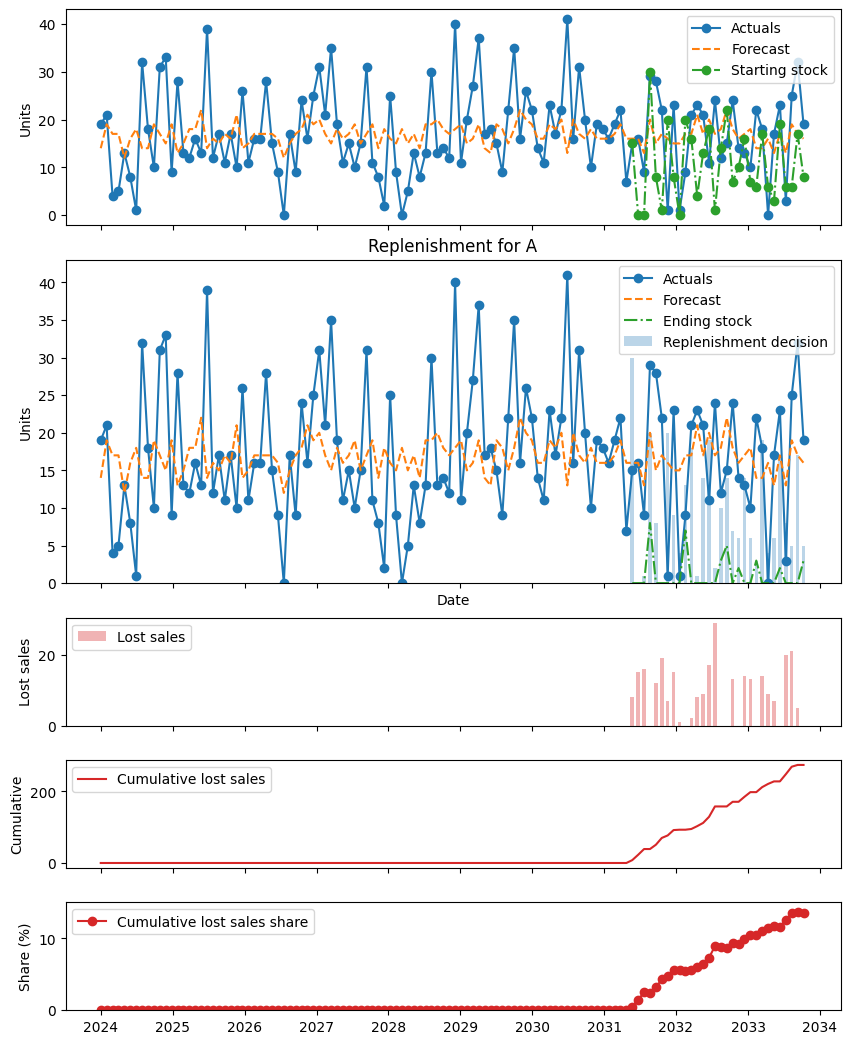

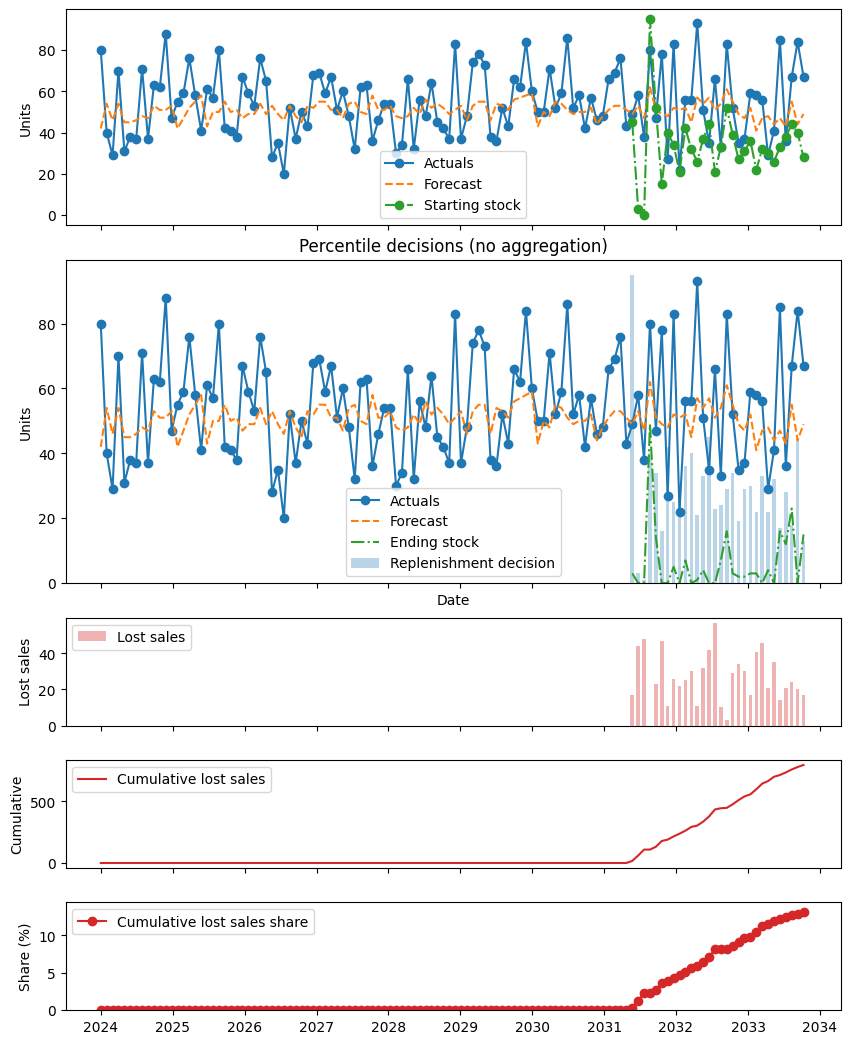

In [6]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, percentile_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    percentile_decision_df,
    aggregate=True,
    title="Percentile decisions (no aggregation)",
)


## Step 2: Optimize Aggregation Window + Percentile Target


In [7]:
agg_percentile_results = optimize_aggregation_and_forecast_targets(
    percentile_configs,
    candidate_windows=[7, 8, 9, 10],
)

forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=True,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
)
forecast_percentile_simulations = {}
for unique_id, config in forecast_percentile_configs.items():
    choice = agg_percentile_results[unique_id]
    policy = PercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[choice.target],
        lead_time=config.lead_time,
    )
    forecast_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=choice.window,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

agg_percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_percentile_simulations,
    aggregation_window={
        uid: agg_percentile_results[uid].window
        for uid in forecast_percentile_simulations
    },
    percentile_target={
        uid: agg_percentile_results[uid].target
        for uid in forecast_percentile_simulations
    },
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
agg_percentile_decision_df = replenishment_decision_rows_to_dataframe(
    agg_percentile_decision_rows,
    library="pandas",
)
agg_percentile_decision_df.head(10)


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2031-05-24,178,23,14.333333,19.777778,40.0,169.0,0,15,...,None,15,0,0,178,0,8,None,9,p40
1,A,2031-06-23,0,15,14.444444,19.888889,44.0,174.0,0,0,...,None,0,0,0,178,0,15,None,9,p40
2,A,2031-07-23,0,16,14.555556,20.333333,44.0,175.0,0,0,...,None,0,0,0,178,0,16,None,9,p40
3,A,2031-08-22,0,22,15.333333,20.666667,47.0,185.0,178,178,...,None,178,156,156,0,0,0,None,9,p40
4,A,2031-09-21,0,20,15.000000,20.444444,43.0,178.0,0,156,...,None,156,136,136,0,0,0,None,9,p40
5,A,2031-10-21,0,20,15.444444,21.111111,43.0,182.0,0,136,...,None,136,116,116,0,0,0,None,9,p40
6,A,2031-11-20,0,27,15.444444,21.222222,42.0,181.0,0,116,...,None,116,89,89,0,0,0,None,9,p40
7,A,2031-12-20,0,23,15.666667,21.222222,43.0,184.0,0,89,...,None,89,66,66,0,0,0,None,9,p40
8,A,2032-01-19,0,1,16.333333,21.333333,44.0,191.0,0,66,...,None,66,65,65,0,0,0,None,9,p40
9,A,2032-02-18,142,13,16.555556,21.555556,49.0,198.0,0,65,...,None,65,52,52,142,0,0,None,9,p40


### Plot (Optimized Aggregation)


0      8
1     15
2     16
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     9
20    20
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     2
29     5
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Percentile decisions (optimized aggregation)'}, xlabel='Date', ylabel='Units'>

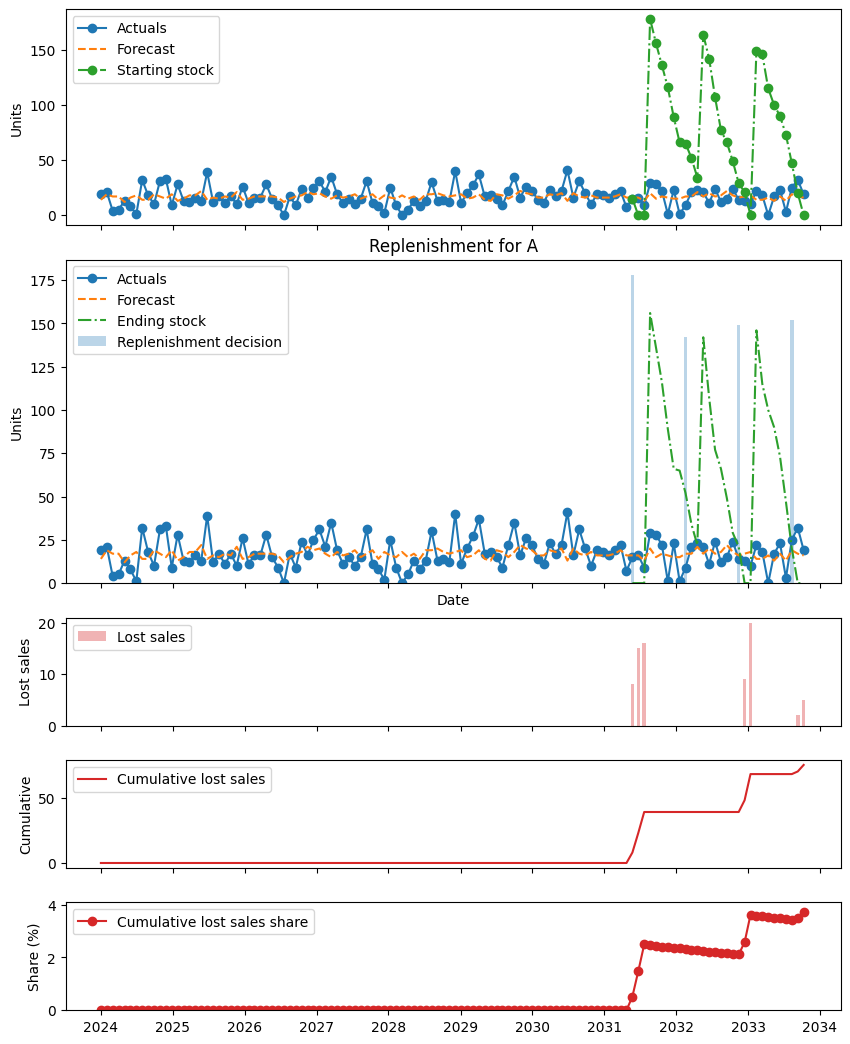

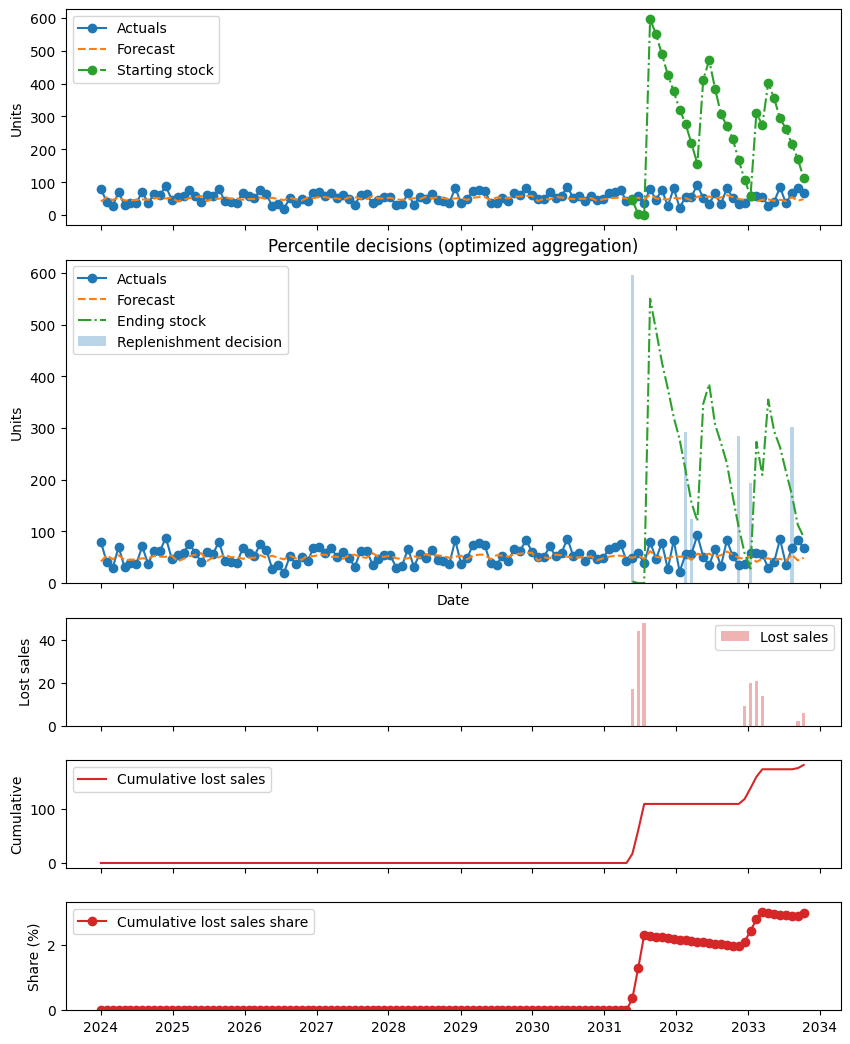

In [8]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, agg_percentile_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    agg_percentile_decision_df,
    aggregate=True,
    title="Percentile decisions (optimized aggregation)",
)


## ROP policy (percentile targets)
This section optimizes percentile targets using a reorder-point trigger.


In [9]:
rop_percentile_results = optimize_forecast_targets(
    percentile_configs,
    policy_mode="rop",
)
rop_percentile_results


{'A': PercentileForecastOptimizationResult(target='p10', policy=RopPercentileForecastOptimizationPolicy(forecast=[8, 11, 10, 10, 7, 10, 11, 8, 8, 11, 10, 9, 11, 8, 9, 11, 11, 13, 8, 10, 9, 10, 10, 13, 8, 9, 10, 10, 10, 10, 10, 7, 9, 10, 11, 13, 11, 12, 10, 9, 11, 10, 10, 11, 9, 10, 11, 8, 11, 10, 9, 11, 9, 10, 8, 11, 11, 12, 11, 10, 11, 11, 9, 10, 11, 8, 8, 11, 11, 9, 11, 13, 12, 11, 10, 10, 11, 11, 12, 8, 12, 10, 10, 11, 10, 10, 10, 10, 11, 10], lead_time=3, aggregation_window=1), simulation=SimulationResult(snapshots=[InventorySnapshot(period=0, starting_on_hand=15, demand=19, received=0, ending_on_hand=0, backorders=0, order_placed=37, on_order=37), InventorySnapshot(period=1, starting_on_hand=0, demand=21, received=0, ending_on_hand=0, backorders=0, order_placed=0, on_order=37), InventorySnapshot(period=2, starting_on_hand=0, demand=4, received=0, ending_on_hand=0, backorders=0, order_placed=0, on_order=37), InventorySnapshot(period=3, starting_on_hand=37, demand=5, received=37, en

In [10]:
rop_forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
)
rop_percentile_simulations = {}
for unique_id, config in rop_forecast_percentile_configs.items():
    target = rop_percentile_results[unique_id].target
    policy = RopPercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[target],
        lead_time=config.lead_time,
    )
    rop_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=1,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
rop_percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    rop_percentile_simulations,
    percentile_target={
        uid: rop_percentile_results[uid].target
        for uid in rop_percentile_simulations
    },
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
rop_percentile_decision_df = replenishment_decision_rows_to_dataframe(
    rop_percentile_decision_rows,
    library="pandas",
)
rop_percentile_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2031-05-24,38,23,10,30,28.0,38.0,0,15,...,None,15,0,0,38,0,8,None,1,p10
1,A,2031-06-23,0,15,10,29,30.0,40.0,0,0,...,None,0,0,0,38,0,15,None,1,p10
2,A,2031-07-23,0,16,8,31,29.0,37.0,0,0,...,None,0,0,0,38,0,16,None,1,p10
3,A,2031-08-22,27,22,12,29,31.0,43.0,38,38,...,None,38,16,16,27,0,0,None,1,p10
4,A,2031-09-21,11,20,9,29,29.0,38.0,0,16,...,None,16,0,0,38,0,4,None,1,p10


0      8
1     15
2     16
3      0
4      4
5     20
6      0
7     12
8      1
9      0
10     0
11     6
12     3
13    17
14    30
15     0
16     0
17     3
18     0
19     8
20     8
21     3
22     4
23     4
24    10
25     0
26     5
27    27
28     4
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

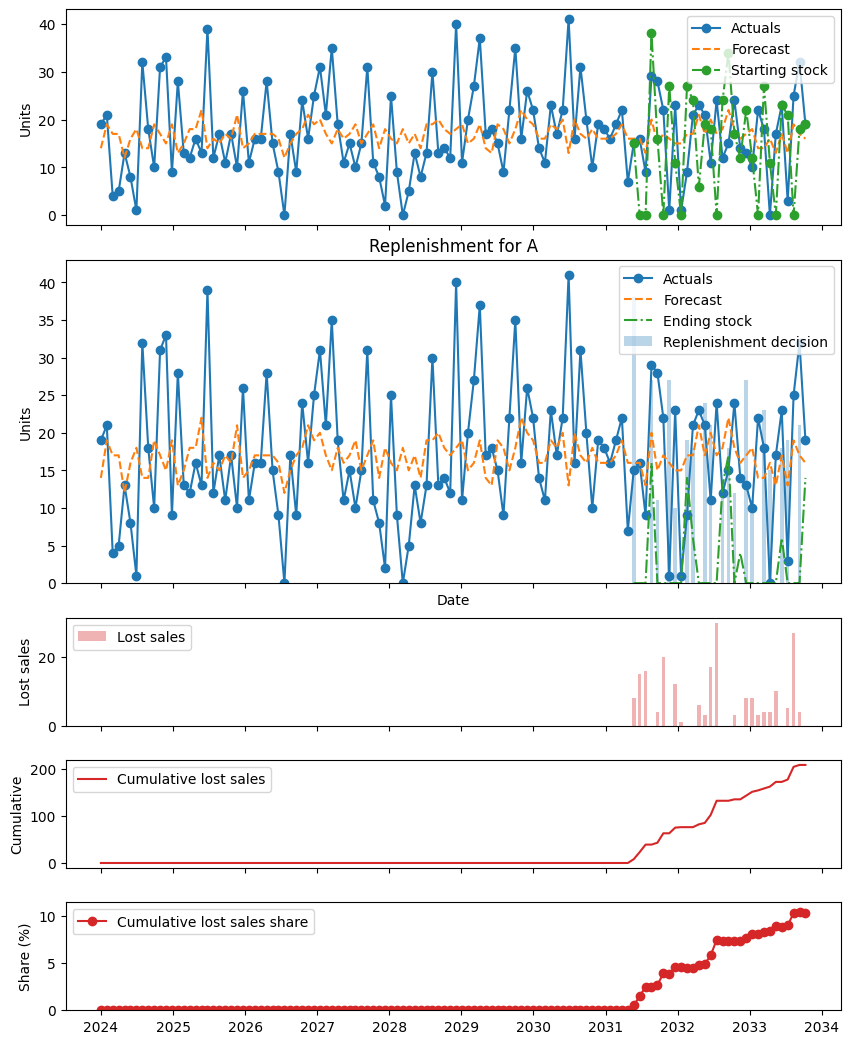

In [11]:
plot_replenishment_decisions(df, rop_percentile_decision_df, unique_id=example_id)


## ROP policy with aggregation window optimization
Uses time-aggregated optimization to select both window and percentile.


In [12]:
rop_agg_results = optimize_aggregation_and_forecast_targets(
    percentile_configs,
    candidate_windows=[7, 8, 9, 10],
    policy_mode="rop",
)
rop_agg_results


{'A': AggregationForecastTargetOptimizationResult(window=9, target='p10', policy=RopPercentileForecastOptimizationPolicy(forecast=[83, 93, 87, 90, 93, 89, 94, 92, 97, 92], lead_time=1, aggregation_window=1), simulation=SimulationResult(snapshots=[InventorySnapshot(period=0, starting_on_hand=15, demand=121, received=0, ending_on_hand=0, backorders=0, order_placed=166, on_order=166), InventorySnapshot(period=1, starting_on_hand=166, demand=165, received=166, ending_on_hand=1, backorders=0, order_placed=185, on_order=185), InventorySnapshot(period=2, starting_on_hand=186, demand=159, received=185, ending_on_hand=27, backorders=0, order_placed=147, on_order=147), InventorySnapshot(period=3, starting_on_hand=174, demand=134, received=147, ending_on_hand=40, backorders=0, order_placed=140, on_order=140), InventorySnapshot(period=4, starting_on_hand=180, demand=182, received=140, ending_on_hand=0, backorders=0, order_placed=186, on_order=186), InventorySnapshot(period=5, starting_on_hand=186,

In [13]:
rop_agg_forecast_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
)
rop_agg_simulations = {}
for unique_id, config in rop_agg_forecast_configs.items():
    choice = rop_agg_results[unique_id]
    policy = RopPercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[choice.target],
        lead_time=config.lead_time,
        aggregation_window=choice.window,
    )
    rop_agg_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=choice.window,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
rop_agg_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    rop_agg_simulations,
    aggregation_window={
        uid: rop_agg_results[uid].window
        for uid in rop_agg_simulations
    },
    percentile_target={
        uid: rop_agg_results[uid].target
        for uid in rop_agg_simulations
    },
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
rop_agg_decision_df = replenishment_decision_rows_to_dataframe(
    rop_agg_decision_rows,
    library="pandas",
)
rop_agg_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2031-05-24,115,23,9.666667,13.333333,28.0,115.0,0,15,...,None,15,0,0,115,0,8,None,9,p10
1,A,2031-06-23,0,15,9.666667,13.333333,30.0,117.0,0,0,...,None,0,0,0,115,0,15,None,9,p10
2,A,2031-07-23,0,16,9.666667,13.555556,29.0,116.0,0,0,...,None,0,0,0,115,0,16,None,9,p10
3,A,2031-08-22,0,22,10.222222,13.777778,31.0,123.0,115,115,...,None,115,93,93,0,0,0,None,9,p10
4,A,2031-09-21,0,20,10.000000,13.666667,29.0,119.0,0,93,...,None,93,73,73,0,0,0,None,9,p10


0      8
1     15
2     16
3      0
4      0
5      0
6      0
7      0
8      0
9     11
10    18
11    12
12     0
13     0
14     0
15     0
16     0
17     2
18     8
19    30
20    20
21     0
22     0
23     0
24     0
25     0
26     0
27    15
28    22
29     5
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

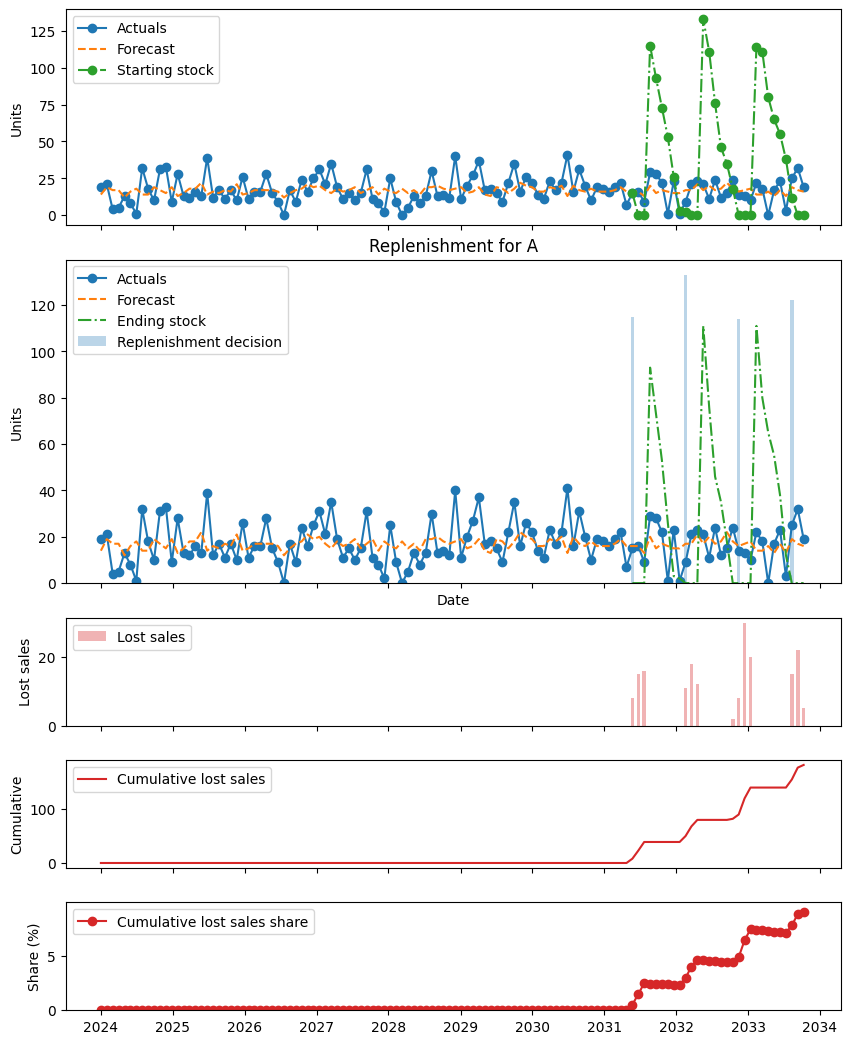

In [14]:
plot_replenishment_decisions(df, rop_agg_decision_df, unique_id=example_id)
